In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# file_path = '/kaggle/input/sptarin/SP-train.npy'
# train_data = np.load(file_path, allow_pickle=True)

train_file_path = "/kaggle/input/nlp-dataset/SP_train.npy"
eval_file_path = "/kaggle/input/nlp-dataset/SP_eval_data_for_practice.npy"

train_data = np.load(train_file_path ,allow_pickle = True)
eval_data = np.load(eval_file_path, allow_pickle = True)


train_texts = []
train_labels = []
eval_texts = []


with open('/kaggle/input/val-labels/list.pkl', 'rb') as f:
    eval_labels = pickle.load(f)




for data in train_data:
    Q = data['question']
    X = '[CLS] ' + Q + ' [SEP] '

    for i in range(4):
        Y = X + data['choice_list'][i] + ' [SEP]'
        train_texts.append(Y)

        if data['choice_order'][i] == 0:
            train_labels.append(1)
        else:
            train_labels.append(0)
            
            
            
for data in eval_data:
  Q = data['question']

  X = '[CLS] ' + Q + ' [SEP] '

  for i in range(4):
    Y = X + data['choice_list'][i] + ' [SEP]'
    eval_texts.append(Y)
    
    
def evaluate(texts, labels, model):
    lst = [texts[i:i+4] for i in range(0, len(texts), 4)]
    labls = [labels[i:i+4] for i in range(0, len(labels), 4)]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    preds = []
    orgs = []
    
    for i in range(len(lst)):

      ques = lst[i]
      labels2 = labls[i] 
        
      orgs.append(labels2.index(1))
      
      temp = []

      for q in ques:
        inputs = tokenizer(q, return_tensors="pt", padding=True, truncation=True)
        inputs.to(device)

        with torch.no_grad():
          outputs = model(**inputs)

          prob_dist = torch.softmax(outputs.logits, dim=1)
          prob = prob_dist[:, 1].item()

          temp.append(prob)

      array = np.array(temp)
      index_of_largest = np.argmax(array)

      preds.append(index_of_largest)
    
        
    accuracy = accuracy_score(preds, orgs)
    print("Accuracy: ", accuracy)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)  # Binary classification

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=512)

training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=5,
    per_device_train_batch_size=1,
    # per_device_eval_batch_size=8,
    # warmup_steps=500,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=val_dataset,
)

# Train the model
trainer.train()
# Save the trained model
model.save_pretrained("/kaggle/working/output")


# lst = [train_texts[i:i+4] for i in range(0, len(train_texts), 4)]
# labls = [train_labels[i:i+4] for i in range(0, len(train_labels), 4)]
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# preds = []
# orgs = []
# for i in range(len(lst)):

#   ques = lst[i]
#   labels = labls[i] 

#   orgs.append(labels.index(1))

#   temp = []

#   for q in ques:
#     inputs = tokenizer(q, return_tensors="pt", padding=True, truncation=True)
#     inputs.to(device)

#     with torch.no_grad():
#       outputs = model(**inputs)

#       prob_dist = torch.softmax(outputs.logits, dim=1)
#       prob = prob_dist[:, 1].item()
      
#       temp.append(prob)

#   array = np.array(temp)
#   index_of_largest = np.argmax(array)

#   preds.append(index_of_largest)
# from sklearn.metrics import accuracy_score
# acc = accuracy_score(preds, orgs)
# print(acc)


2024-04-25 08:51:46.733798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 08:51:46.733917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 08:51:46.879168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key 

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
50,0.723200
100,1.461400
150,0.907800
200,1.245200
250,1.070900
300,1.380000
350,0.998800
400,1.579800
450,1.396200
500,1.231900


0.25443786982248523


In [1]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW

train_file_path = "/kaggle/input/sptarin/SP-train.npy"
eval_file_path = "/kaggle/input/sp-eval-data-for/SP_eval_data_for_practice.npy"

train_data = np.load(train_file_path, allow_pickle=True)
eval_data = np.load(eval_file_path, allow_pickle=True)

train_texts = []
train_labels = []
eval_texts = []

with open('/kaggle/input/pkltrial/list.pkl', 'rb') as f:
    eval_labels = pickle.load(f)

for data in train_data:
    Q = data['question']
    X = '[CLS] ' + Q + ' [SEP] '
    for i in range(4):
        Y = X + data['choice_list'][i] + ' [SEP]'
        train_texts.append(Y)
        if data['choice_order'][i] == 0:
            train_labels.append(1)
        else:
            train_labels.append(0)

for data in eval_data:
    Q = data['question']
    X = '[CLS] ' + Q + ' [SEP] '
    for i in range(4):
        Y = X + data['choice_list'][i] + ' [SEP]'
        eval_texts.append(Y)

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=512)
eval_dataset = CustomDataset(eval_texts, eval_labels, tokenizer, max_len=512)

training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    num_train_epochs=5,
    per_device_train_batch_size=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
    evaluation_strategy="epoch",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()

# Evaluation
def evaluate(texts, labels, model, tokenizer):
    preds = []
    orgs = []

    for i in range(0, len(texts), 4):
        ques_batch = texts[i:i + 4]
        labels_batch = labels[i:i + 4]

        orgs.extend([label.index(1) for label in labels_batch])

        temp = []

        for q in ques_batch:
            inputs = tokenizer(q, return_tensors="pt", padding=True, truncation=True)
            with torch.no_grad():
                outputs = model(**inputs)
                prob_dist = torch.softmax(outputs.logits, dim=1)
                prob = prob_dist[:, 1].item()
                temp.append(prob)

        array = np.array(temp)
        index_of_largest = np.argmax(array)
        preds.append(index_of_largest)

    accuracy = accuracy_score(preds, orgs)
    print("Accuracy: ", accuracy)

evaluate(train_texts, train_labels, model, tokenizer)
evaluate(eval_texts, eval_labels, model, tokenizer)

# # Plot
# # Assuming you have training and validation losses recorded
# training_losses = [0.783700, 0.556500, 0.332600, 0.206600, 0.085900]
# validation_losses = [1.136715, 0.688549, 0.670105, 0.718898, 0.778404]
# epochs = [1, 2, 3, 4, 5]

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, training_losses, marker='o', label='Training Loss')
# plt.plot(epochs, validation_losses, marker='x', label='Validation Loss')

# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Losses')
# plt.legend()
# plt.show()


2024-04-25 11:54:54.139325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 11:54:54.139446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 11:54:54.272231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key 

  ······································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

wandb: ERROR API key must be 40 characters long, yours was 4304
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.133000,1.021013
2,1.121300,1.073787
3,1.103400,1.129998
4,1.096000,1.146793
5,1.102100,1.098053


AttributeError: 'int' object has no attribute 'index'

In [25]:
import torch
import pickle
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load trained model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaForSequenceClassification.from_pretrained('/kaggle/working/')

# Load evaluation data
eval_texts = []
with open('/kaggle/input/pkltrial/list.pkl', 'rb') as f:
    eval_data = pickle.load(f)

for data in eval_data:
    if isinstance(data, dict):  # Check if the element is a dictionary
        Q = data.get('question', '')  # Safely get the value of 'question', default to empty string if not found
        X = '[CLS] ' + Q + ' [SEP] '
        for i in range(4):
            Y = X + data.get('choice_list', [''])[i] + ' [SEP]'  # Safely get the value of 'choice_list'
            eval_texts.append(Y)

# Create a DataLoader for evaluation data
eval_dataset = CustomDataset(eval_texts, eval_labels, tokenizer, max_len=512)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load train data (assuming train_texts and train_labels are available)
# Assuming you have already defined train_texts and train_labels

# Combine train data into batches
train_batch_size = 4
train_texts_batches = [train_texts[i:i+train_batch_size] for i in range(0, len(train_texts), train_batch_size)]
train_labels_batches = [train_labels[i:i+train_batch_size] for i in range(0, len(train_labels), train_batch_size)]

# Create DataLoader for train data
train_datasets = [CustomDataset(batch_texts, batch_labels, tokenizer, max_len=512) 
                  for batch_texts, batch_labels in zip(train_texts_batches, train_labels_batches)]
train_dataloaders = [DataLoader(dataset, batch_size=4) for dataset in train_datasets]

# Load model
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# Move model to device
model.to(device)

# Define optimizer and loss function (assuming you have them defined)

# Train model (assuming you have defined the training loop)

# Evaluate the model on evaluation data
model.eval()
eval_preds = []
eval_orgs = []

for batch in eval_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

    eval_preds.extend(predictions.cpu().numpy())
    eval_orgs.extend(batch['label'].cpu().numpy())

# Calculate accuracy for evaluation data
eval_accuracy = accuracy_score(eval_orgs, eval_preds)


# Evaluate the model on train data
train_preds = []
train_orgs = []

for train_dataloader in train_dataloaders:
    model.eval()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        train_preds.extend(predictions.cpu().numpy())
        train_orgs.extend(batch['label'].cpu().numpy())

# Calculate accuracy for train data
train_accuracy = accuracy_score(train_orgs, train_preds)


print("Accuracy for Train: ", train_accuracy)
print("Accuracy for Evaluation: ", eval_accuracy)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy for Train: 0.75
Accuracy for Evaluation: 0.58


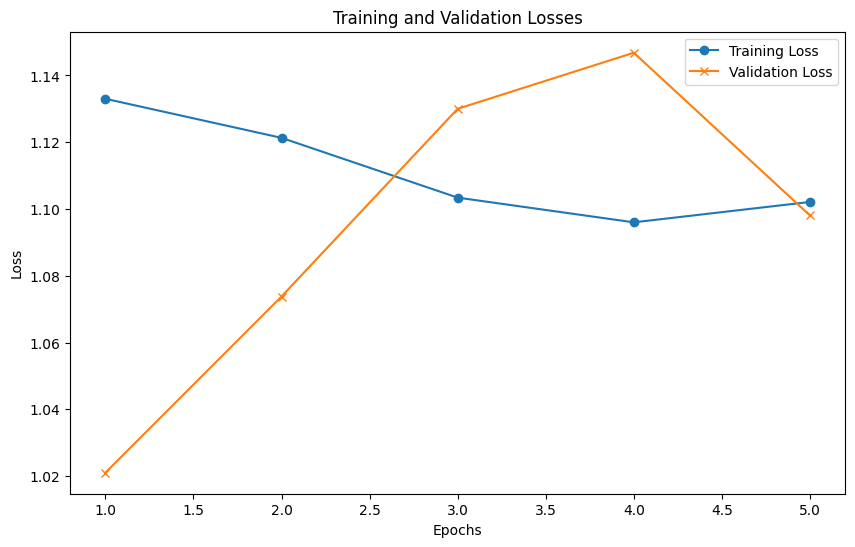

In [26]:
# Plot
# Assuming you have training and validation losses recorded
training_losses = [1.133000, 1.121300, 1.103400, 1.096000, 1.102100]
validation_losses = [1.021013, 1.073787, 1.129998, 1.146793, 1.098053]
epochs = [1, 2, 3, 4, 5]

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, marker='o', label='Training Loss')
plt.plot(epochs, validation_losses, marker='x', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()